In [ ]:
!pip install opencv-contrib-python


<IPython.core.display.Javascript object>

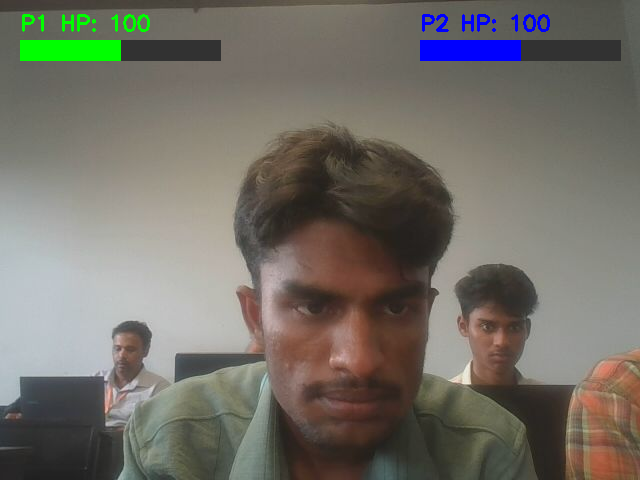

<IPython.core.display.Javascript object>

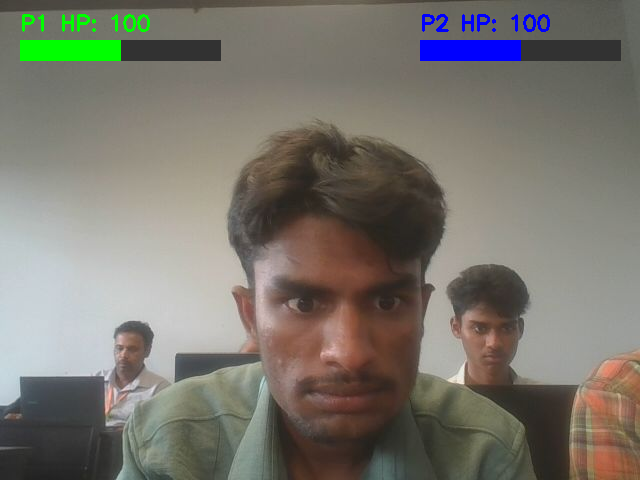

<IPython.core.display.Javascript object>

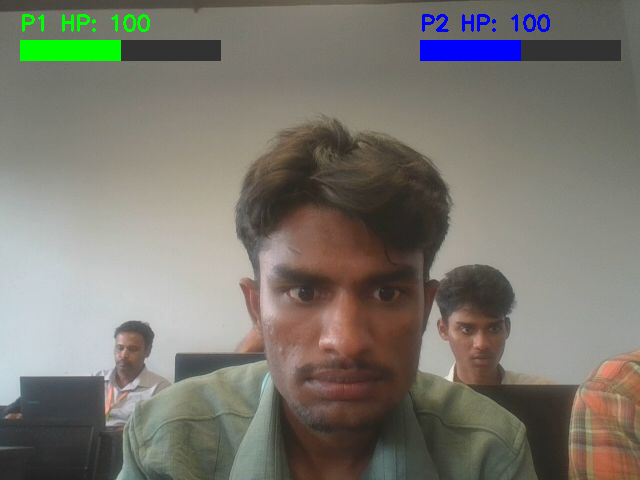

<IPython.core.display.Javascript object>

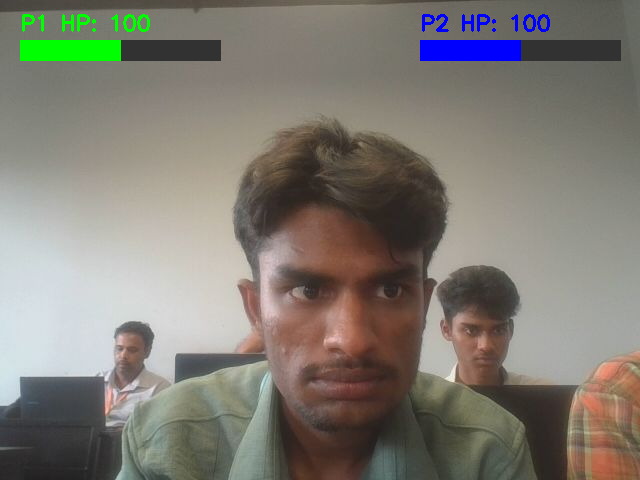

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import time
aruco = cv2.aruco
dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters()

cards = {
    0: ["Warrior", 10],
    1: ["Mage", 15],
    2: ["Tank", 5],
    3: ["Archer", 12]
}

player1_hp = 100
player2_hp = 100

def capture_frame():
    js = Javascript('''
    async function capture() {
        const video = document.createElement('video');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(video);
        video.srcObject = stream;
        await video.play();

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks()[0].stop();
        video.remove();
        return canvas.toDataURL('image/jpeg', 0.8);
    }
    capture();
    ''')
    display(js)
    data = eval_js("capture()")
    binary = b64decode(data.split(',')[1])
    img = np.frombuffer(binary, dtype=np.uint8)
    return cv2.imdecode(img, cv2.IMREAD_COLOR)

def draw_health_bar(frame, hp, x, y, color):
    hp = max(0, hp)
    cv2.rectangle(frame, (x, y), (x+200, y+20), (50,50,50), -1)
    cv2.rectangle(frame, (x, y), (x+2*hp, y+20), color, -1)

while True:

    frame = capture_frame()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, _ = aruco.detectMarkers(gray, dictionary, parameters=parameters)

    height, width, _ = frame.shape
    player1_card = None
    player2_card = None

    if ids is not None:
        aruco.drawDetectedMarkers(frame, corners, ids)

        for i in range(len(ids)):
            marker_id = ids[i][0]

            if marker_id in cards:

                corner = corners[i][0]
                center_x = int(corner[:,0].mean())
                center_y = int(corner[:,1].mean())

                card_name = cards[marker_id][0]
                attack = cards[marker_id][1]

                if center_x < width // 2:
                    player1_card = marker_id
                    cv2.putText(frame, f"P1: {card_name}",
                                (center_x, center_y),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.8, (0,255,0), 2)
                else:
                    player2_card = marker_id
                    cv2.putText(frame, f"P2: {card_name}",
                                (center_x, center_y),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.8, (255,0,0), 2)


    if player1_card is not None and player2_card is not None:

        p1_attack = cards[player1_card][1]
        p2_attack = cards[player2_card][1]

        player1_hp -= p2_attack
        player2_hp -= p1_attack

        time.sleep(1)
    # ----------------------------
    # Draw UI
    # ----------------------------
    draw_health_bar(frame, player1_hp//2, 20, 40, (0,255,0))
    draw_health_bar(frame, player2_hp//2, width-220, 40, (255,0,0))

    cv2.putText(frame, f"P1 HP: {player1_hp}", (20,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    cv2.putText(frame, f"P2 HP: {player2_hp}", (width-220,30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

    if player1_hp <= 0:
        cv2.putText(frame, "PLAYER 2 WINS!",
                    (width//4, height//2),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5,
                    (0,0,255), 3)
        cv2_imshow(frame)
        break

    if player2_hp <= 0:
        cv2.putText(frame, "PLAYER 1 WINS!",
                    (width//4, height//2),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5,
                    (0,0,255), 3)
        cv2_imshow(frame)
        break

    cv2_imshow(frame)



In [ ]:
!pip install mediapipe opencv-python

  Using cached mediapipe-0.10.32-py3-none-manylinux_2_28_x86_64.whl.metadata (9.8 kB)
Using cached mediapipe-0.10.32-py3-none-manylinux_2_28_x86_64.whl (10.3 MB)


In [ ]:
!wget -O hand_landmarker.task \
https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


--2026-02-14 07:46:21--  https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 192.178.212.207, 172.217.214.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7819105 (7.5M) [application/octet-stream]
Saving to: ‘hand_landmarker.task’

hand_landmarker.tas 100%[===================>]   7.46M  --.-KB/s    in 0.08s   

2026-02-14 07:46:21 (97.1 MB/s) - ‘hand_landmarker.task’ saved [7819105/7819105]



<IPython.core.display.Javascript object>

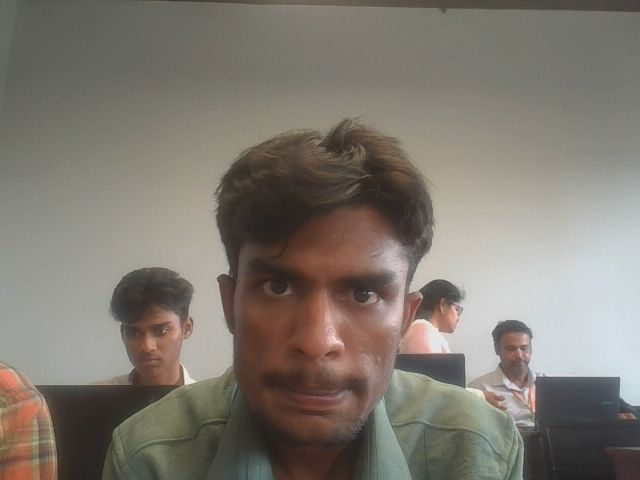

<IPython.core.display.Javascript object>

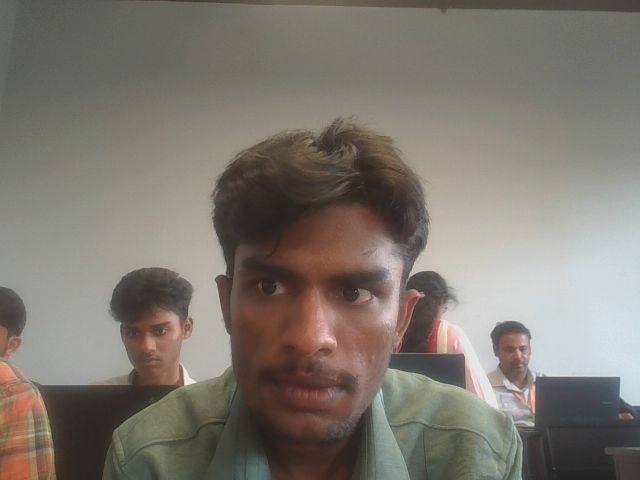

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import time

def capture_frame():
    js = Javascript('''
    async function capture() {
        const video = document.createElement('video');
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(video);
        video.srcObject = stream;
        await video.play();

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks()[0].stop();
        video.remove();
        return canvas.toDataURL('image/jpeg', 0.8);
    }
    capture();
    ''')
    display(js)
    data = eval_js("capture()")
    binary = b64decode(data.split(',')[1])
    img = np.frombuffer(binary, dtype=np.uint8)
    return cv2.imdecode(img, cv2.IMREAD_COLOR)


base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')

options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1
)

detector = vision.HandLandmarker.create_from_options(options)

def is_fist(landmarks):
    tips = [8, 12, 16, 20]
    folded = 0
    for tip in tips:
        if landmarks[tip].y > landmarks[tip - 2].y:
            folded += 1
    return folded >= 3

# ----------------------------
# Draw Puppet
# ----------------------------
def draw_puppet(frame, cx, cy, landmarks, sleeping=False):

    cv2.circle(frame, (cx, cy), 40, (0,255,255), -1)

    if sleeping:
        cv2.line(frame, (cx-15, cy-10), (cx-5, cy-10), (0,0,0), 3)
        cv2.line(frame, (cx+5, cy-10), (cx+15, cy-10), (0,0,0), 3)
        cv2.putText(frame, "Sleeping...",
                    (cx-40, cy-60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,255), 2)
    else:
        cv2.circle(frame, (cx-10, cy-10), 5, (0,0,0), -1)
        cv2.circle(frame, (cx+10, cy-10), 5, (0,0,0), -1)

    cv2.ellipse(frame, (cx, cy+5), (15,10), 0, 0, 180, (0,0,0), 2)

    index_x = int(landmarks[8].x * frame.shape[1])
    index_y = int(landmarks[8].y * frame.shape[0])

    cv2.line(frame, (cx-40, cy), (index_x, index_y), (255,0,0), 4)
    cv2.line(frame, (cx+40, cy), (index_x, index_y), (255,0,0), 4)

    cv2.line(frame, (cx-20, cy+40), (cx-20, cy+80), (0,255,0), 4)
    cv2.line(frame, (cx+20, cy+40), (cx+20, cy+80), (0,255,0), 4)


while True:

    frame = capture_frame()
    frame = cv2.flip(frame, 1)

    mp_image = mp.Image(
        image_format=mp.ImageFormat.SRGB,
        data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    )

    result = detector.detect(mp_image)

    if result.hand_landmarks:
        landmarks = result.hand_landmarks[0]

        wrist = landmarks[0]
        cx = int(wrist.x * frame.shape[1])
        cy = int(wrist.y * frame.shape[0])

        sleeping = is_fist(landmarks)
        draw_puppet(frame, cx, cy, landmarks, sleeping)

    cv2_imshow(frame)
    time.sleep(0.5)
